Group Members: Asha Karmakar, Akhil Iyer, Megan Sundheim, Grace Kim
Asha -
Grace -
Akhil - 
Megan - 

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

<p> https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features </p>

<h1> Data Preprocessing & Exploration </h1>

In [2]:
# Read in csv file
df = pd.read_csv("./data/genres.csv")

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Clean data
# Remove the following columns: type, id, uri, track_href, analysis_url, unnamed, title, song_name
df = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'genre']]

In [4]:
# one hot encode time signature
df = pd.get_dummies(df, columns=['time_signature'], drop_first=False)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genre,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.831,0.814,2,-7.364,1,0.4200,0.059800,0.013400,0.0556,0.3890,156.985,124539,Dark Trap,0,0,1,0
1,0.719,0.493,8,-7.230,1,0.0794,0.401000,0.000000,0.1180,0.1240,115.080,224427,Dark Trap,0,0,1,0
2,0.850,0.893,5,-4.783,1,0.0623,0.013800,0.000004,0.3720,0.0391,218.050,98821,Dark Trap,0,0,1,0
3,0.476,0.781,0,-4.710,1,0.1030,0.023700,0.000000,0.1140,0.1750,186.948,123661,Dark Trap,0,1,0,0
4,0.798,0.624,2,-7.668,1,0.2930,0.217000,0.000000,0.1660,0.5910,147.988,123298,Dark Trap,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42300,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208,hardstyle,0,0,1,0
42301,0.517,0.768,0,-7.922,0,0.0479,0.022500,0.000018,0.2050,0.3830,149.928,210112,hardstyle,0,0,1,0
42302,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823,hardstyle,0,0,1,0
42303,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200,hardstyle,0,0,1,0


In [5]:
# Separate data into features and class labels

features = df.drop(columns=['genre'])
labels = df['genre']

#scaled_data = StandardScaler().fit_transform(features)
#scaled_features = pd.DataFrame(scaled_data, columns=features.columns)

#scaled_features.to_csv('scaled_features.csv', index=False)
#labels.to_csv('labels.csv', index=False)

In [6]:
labels
label_groups = df.groupby('genre')
print(label_groups.size())

genre
Dark Trap          4578
Emo                1680
Hiphop             3028
Pop                 461
Rap                1848
RnB                2099
Trap Metal         1956
Underground Rap    5875
dnb                2966
hardstyle          2936
psytrance          2961
techhouse          2975
techno             2956
trance             2999
trap               2987
dtype: int64


In [7]:
# There are no missing values:
null_data = df[df.isnull().any(axis=1)]
len(null_data)

0

[Text(0.5, 0, 'danceability'),
 Text(1.5, 0, 'energy'),
 Text(2.5, 0, 'key'),
 Text(3.5, 0, 'loudness'),
 Text(4.5, 0, 'mode'),
 Text(5.5, 0, 'speechiness'),
 Text(6.5, 0, 'acousticness'),
 Text(7.5, 0, 'instrumentalness'),
 Text(8.5, 0, 'liveness'),
 Text(9.5, 0, 'valence'),
 Text(10.5, 0, 'tempo'),
 Text(11.5, 0, 'duration_ms'),
 Text(12.5, 0, 'time_signature_1'),
 Text(13.5, 0, 'time_signature_3'),
 Text(14.5, 0, 'time_signature_4'),
 Text(15.5, 0, 'time_signature_5')]

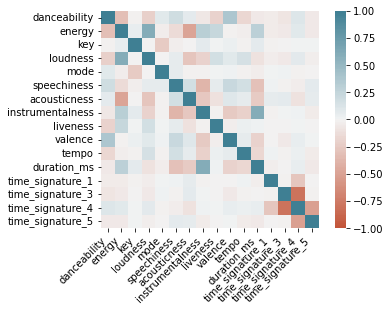

In [8]:
import seaborn as sns

# correlation between features

ax = sns.heatmap(
    features.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

<h1> Model Building </h1>

In [9]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [10]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=4)

scaler = StandardScaler()
pca = PCA()
mlp = MLPClassifier(random_state=1, early_stopping=True)

mlp_param = {
    'mlp__hidden_layer_sizes': list(range(90, 110, 10)),
    'mlp__activation': ('logistic', 'tanh', 'relu'),
    'mlp__solver': ('sgd','adam')
}

mlp_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('mlp', mlp)])
clf = GridSearchCV(mlp_pipe, mlp_param, n_jobs=-1, cv=5)
clf.fit(x_train, y_train) # X is train samples and y is the corresponding labels

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('mlp',
                                        MLPClassifier(early_stopping=True,
                                                      random_state=1))]),
             n_jobs=-1,
             param_grid={'mlp__activation': ('logistic', 'tanh', 'relu'),
                         'mlp__hidden_layer_sizes': [90, 100],
                         'mlp__solver': ('sgd', 'adam')})

In [11]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': 100, 'mlp__solver': 'adam'}


In [19]:
y_true, y_pred = y_test , clf.predict(x_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
                 precision    recall  f1-score   support

      Dark Trap       0.54      0.41      0.47       931
            Emo       0.63      0.65      0.64       356
         Hiphop       0.47      0.39      0.42       620
            Pop       0.50      0.05      0.10        94
            Rap       0.64      0.32      0.42       395
            RnB       0.35      0.37      0.36       414
     Trap Metal       0.49      0.29      0.36       391
Underground Rap       0.43      0.65      0.52      1194
            dnb       0.91      0.94      0.92       578
      hardstyle       0.82      0.91      0.86       609
      psytrance       0.94      0.89      0.91       608
      techhouse       0.84      0.84      0.84       617
         techno       0.80      0.85      0.82       539
         trance       0.78      0.83      0.80       567
           trap       0.80      0.77      0.79       548

       accuracy                           0.66      8461
    

<AxesSubplot:>

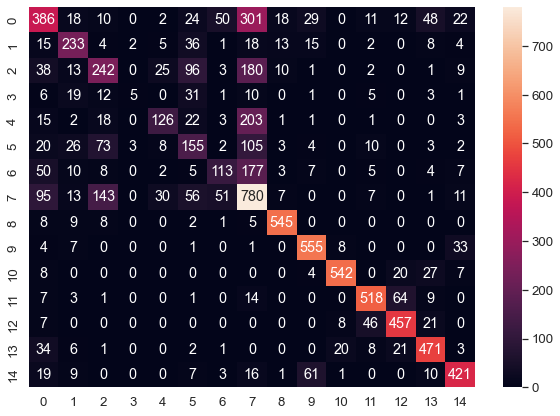

In [24]:
from sklearn import metrics
import seaborn as sn

cm=metrics.confusion_matrix(y_test,y_pred)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
sn.heatmap(cm, annot=True, fmt='g')

#df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEFGHIJK"], columns = [i for i in ])
